<a href="https://colab.research.google.com/github/anushkayadav/Denoising_cifar10/blob/master/aut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms


In [70]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),])
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)



num_workers = 0

batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [44]:
use_cuda = torch.cuda.is_available()

print(use_cuda)

True


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

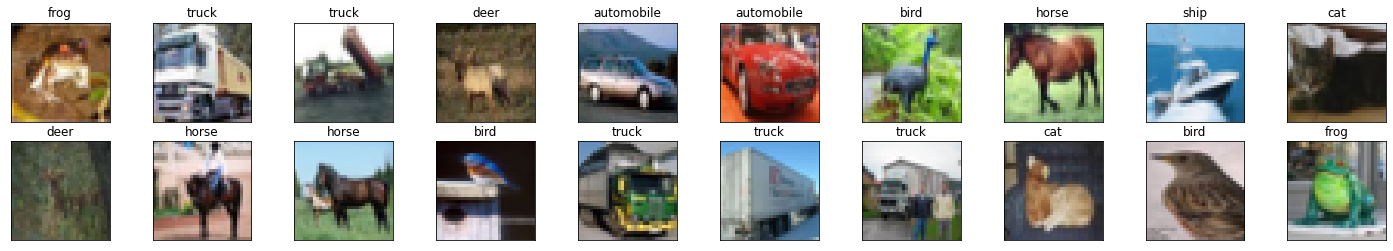

In [46]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

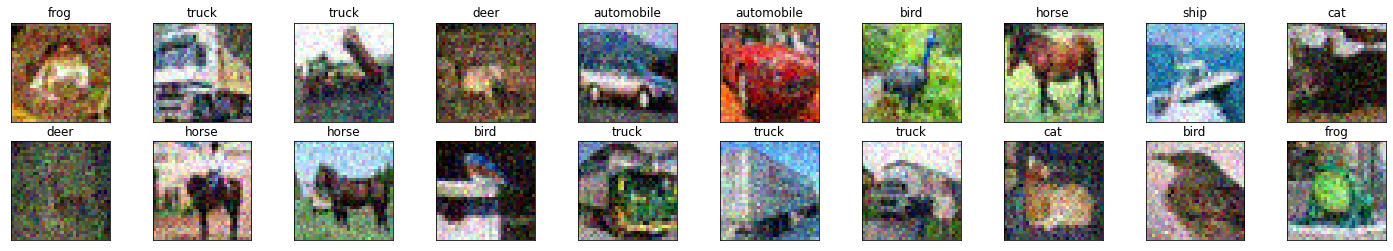

In [47]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
#images = images.numpy() # convert images to numpy for display
noise_factor=0.1
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
# Clip the images to be between 0 and 1
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(noisy_imgs[idx])
    ax.set_title(classes[labels[idx]])

# Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1.

In [88]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(64, 16, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(16, 64, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvDenoiser()
model=model.cuda()
print(model)

ConvDenoiser(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(16, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [89]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [90]:
print(type(train_loader))
for data in train_loader:
  images, target = data
  print(target)
  print(images.shape)
  break

<class 'torch.utils.data.dataloader.DataLoader'>
tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6])
torch.Size([20, 3, 32, 32])


In [91]:
# number of epochs to train the model
n_epochs = 40

# for adding noise to images
noise_factor=0.1

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        noisy_imgs=noisy_imgs.cuda()
        images=images.cuda()
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.158163
Epoch: 2 	Training Loss: 0.099382
Epoch: 3 	Training Loss: 0.090625
Epoch: 4 	Training Loss: 0.086315
Epoch: 5 	Training Loss: 0.083779
Epoch: 6 	Training Loss: 0.082115
Epoch: 7 	Training Loss: 0.080881
Epoch: 8 	Training Loss: 0.080016
Epoch: 9 	Training Loss: 0.079343
Epoch: 10 	Training Loss: 0.078811
Epoch: 11 	Training Loss: 0.078279
Epoch: 12 	Training Loss: 0.077877
Epoch: 13 	Training Loss: 0.077516
Epoch: 14 	Training Loss: 0.077156
Epoch: 15 	Training Loss: 0.076803
Epoch: 16 	Training Loss: 0.076535
Epoch: 17 	Training Loss: 0.076213
Epoch: 18 	Training Loss: 0.075922
Epoch: 19 	Training Loss: 0.075683
Epoch: 20 	Training Loss: 0.075345
Epoch: 21 	Training Loss: 0.075111
Epoch: 22 	Training Loss: 0.074885
Epoch: 23 	Training Loss: 0.074693
Epoch: 24 	Training Loss: 0.074520
Epoch: 25 	Training Loss: 0.074316
Epoch: 26 	Training Loss: 0.074188
Epoch: 27 	Training Loss: 0.074009
Epoch: 28 	Training Loss: 0.073878
Epoch: 29 	Training Loss: 0.0

In [92]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.cuda())



# output is resized into a batch of iages
output = output.view(batch_size, 3, 32, 32)
# use detach when it's an output that requires_grad
output = output.detach()



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## **NOISY IMAGES**

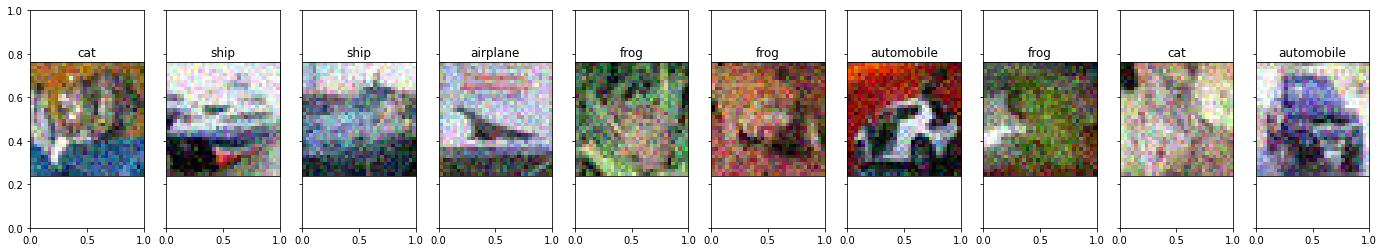

In [82]:
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(10):
    ax = fig.add_subplot(1, 20/2, idx+1, xticks=[], yticks=[])
    imshow(noisy_imgs[idx])
    
    ax.set_title(classes[labels[idx]])

## DENOISED IMAGES

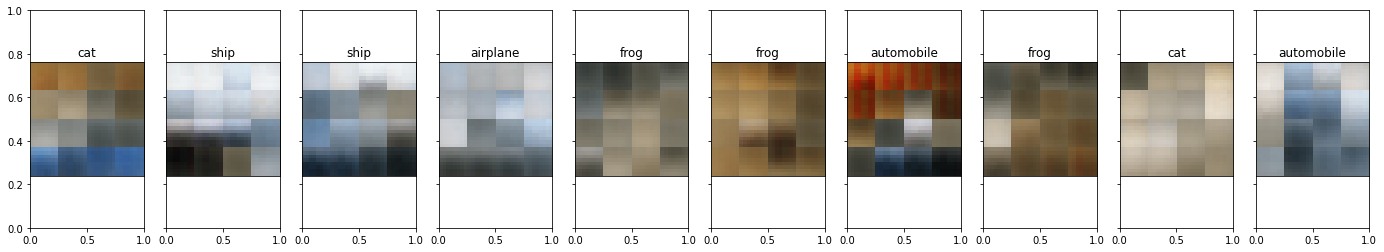

In [69]:
output=output.cpu().clone()
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(10):
    ax = fig.add_subplot(1, 20/2, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])

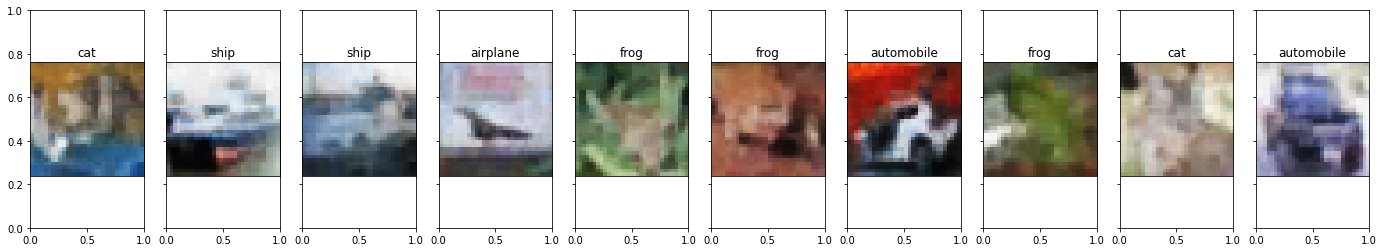

In [93]:
output=output.cpu().clone()
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(10):
    ax = fig.add_subplot(1, 20/2, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])